# Datawhale 零基础入门数据挖掘-Task1 赛题理解

## Task1赛题理解

--- 赛题以心电图数据为背景，根据心电图感应数据预测心跳信号，其中心跳信号对应正常病例以及受不同心律不齐和心肌梗塞影响的病例，这是一个多分类的问题。通过这道赛题来引导大家了解医疗大数据的应用，帮助竞赛新人进行自我练习、自我提高。



In [1]:
import os
import gc
import math

import pandas as pd
import numpy as np

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
D:\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
D:\Anaconda\lib\site-pa

In [24]:
import matplotlib.pyplot as plt


## 数据集
---数据来自某平台心电图数据记录，总数据量超过20万，主要为1列心跳信号序列数据，其中每个样本的信号序列采样频次一致，长度相等。为了保证比赛的公平性，将会从中抽取10万条作为训练集，2万条作为测试集A，2万条作为测试集B，同时会对心跳信号类别（label）信息进行脱敏。


In [67]:
train = pd.read_csv('data/train.csv')
test=pd.read_csv('data/testA.csv')
result=pd.read_csv('sample_submit.csv')
print('Dataset Loaded')

Dataset Loaded


# 数据预处理

In [4]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
train_list = []

for items in train.values:
    train_list.append([items[0]] + [float(i) for i in items[1].split(',')] + [items[2]])

train = pd.DataFrame(np.array(train_list))
train.columns = ['id'] + ['s_'+str(i) for i in range(len(train_list[0])-2)] + ['label']
train = reduce_mem_usage(train)

test_list=[]
for items in test.values:
    test_list.append([items[0]] + [float(i) for i in items[1].split(',')])

test = pd.DataFrame(np.array(test_list))
test.columns = ['id'] + ['s_'+str(i) for i in range(len(test_list[0])-1)]
test = reduce_mem_usage(test)

result_list=[]
for items in result.values:
    result_list.append([items[0]] + [float(i) for i in items[1].split(',')])

result = pd.DataFrame(np.array(result_list))
result.columns = ['id'] + ['s_'+str(i) for i in range(len(result_list[0])-1)]
result = reduce_mem_usage(result)

Memory usage of dataframe is 157.93 MB
Memory usage after optimization is: 39.67 MB
Decreased by 74.9%
Memory usage of dataframe is 31.43 MB
Memory usage after optimization is: 7.90 MB
Decreased by 74.9%


In [7]:

x_train = train.drop(['id','label'], axis=1)
y_train = train['label']
x_test=test.drop(['id'], axis=1)


In [47]:
def split_train(data,test_ratio): 
    np.random.seed(43) 
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio) 
    test_indices =shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:] 
    return data[train_indices],data[test_indices]

In [62]:
train_features=x_train

train_targets = y_train

val_features=x_train[:2000]

val_targets=y_train[:2000]

In [56]:
val_features.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_195,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204
0,0.991211,0.943359,0.764648,0.618652,0.379639,0.190796,0.040222,0.026001,0.031708,0.065552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.971680,0.929199,0.572754,0.178467,0.122986,0.132324,0.094421,0.089600,0.030487,0.040497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.958984,0.701172,0.231812,0.000000,0.080688,0.128418,0.187500,0.280762,0.328369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.975586,0.934082,0.659668,0.249878,0.237061,0.281494,0.249878,0.249878,0.241455,0.230713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.055817,0.261230,0.359863,0.433105,0.453613,0.499023,0.542969,0.616699,0.676758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
x_train.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_195,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204
0,0.991211,0.943359,0.764648,0.618652,0.379639,0.190796,0.040222,0.026001,0.031708,0.065552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.971680,0.929199,0.572754,0.178467,0.122986,0.132324,0.094421,0.089600,0.030487,0.040497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.958984,0.701172,0.231812,0.000000,0.080688,0.128418,0.187500,0.280762,0.328369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.975586,0.934082,0.659668,0.249878,0.237061,0.281494,0.249878,0.249878,0.241455,0.230713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.055817,0.261230,0.359863,0.433105,0.453613,0.499023,0.542969,0.616699,0.676758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
y_train.head()

0    0.0
1    0.0
2    2.0
3    0.0
4    2.0
Name: label, dtype: float16

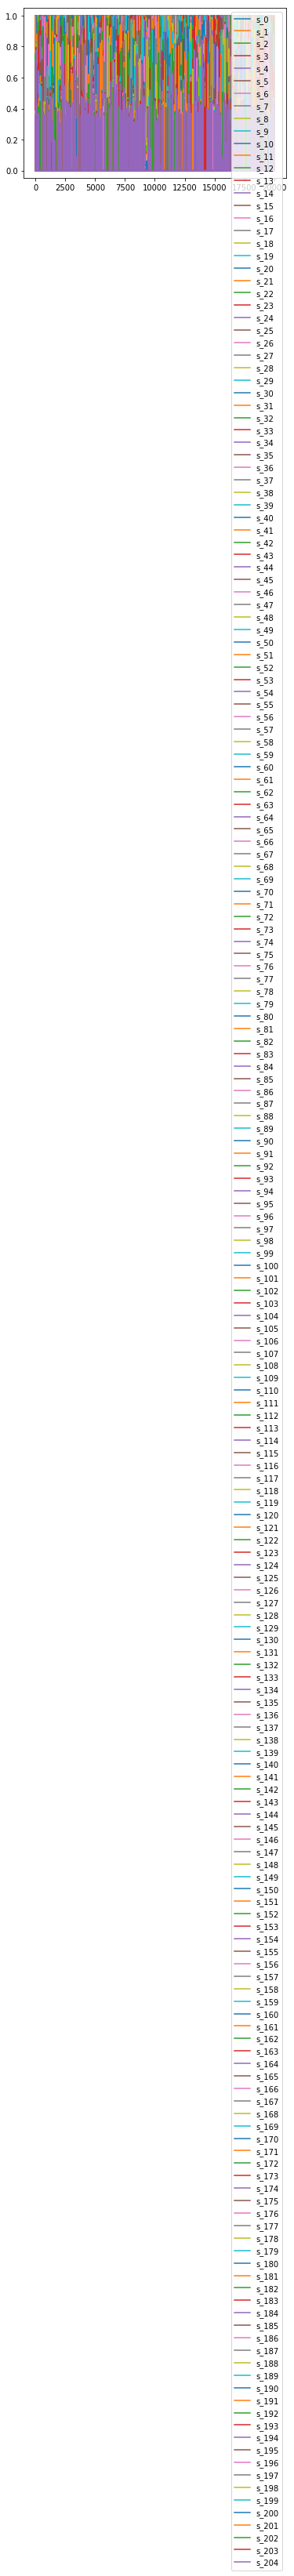

In [23]:
x_test.plot()

## 模型
。 
- 模型 1 是一个简单的前馈神经网络模型
- 模型 2 是一个


In [32]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
       
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
         
        self.activation_function = lambda x: (1 /(1 + np.exp(-x)))   # Replace 0 with your sigmoid calculation.
       
         
    def train(self, features, targets):
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
           
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

           
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer y=x

            error =final_outputs - y # Output layer error is the difference between desired target and actual output.
            output_error_term = error
           
            
            hidden_error = np.dot(output_error_term, self.weights_hidden_to_output.T)
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
            output_error_term = output_error_term
            hidden_error_term = hidden_error_term
            # Weight step (input to hidden)
            delta_weights_i_h += -hidden_error_term * X[:, None]
            # Weight step (hidden to output)
            delta_weights_h_o += -output_error_term * hidden_outputs[:,None]

        
        self.weights_hidden_to_output += self.lr * (delta_weights_h_o/n_records) 
        # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * (delta_weights_i_h/n_records) 
        # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''       
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) 
        hidden_outputs = self.activation_function(hidden_inputs) 
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs
        return final_outputs

In [26]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

随机梯度下降 (SGD) 方法训练网络

In [59]:
import sys


iterations = 8000
learning_rate = 0.8
hidden_nodes = 20
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.loc[batch].values, train_targets.loc[batch]
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets.values)
    val_loss = MSE(network.run(val_features).T, val_targets.values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.290 ... Validation loss: 0.296

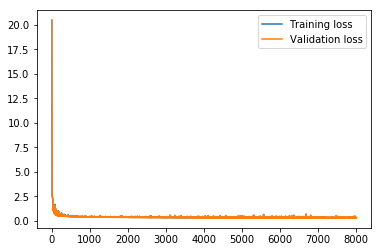

In [60]:

plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

In [78]:
predictions = network.run(x_test)


In [70]:
temp=pd.DataFrame(predictions)
temp


,0
0,0.068657
1,2.472341
2,2.654667
3,0.041676
4,0.024932
...,...
19995,0.180639
19996,0.078045
19997,1.047033
19998,0.008236


ValueError: shapes (100000,) and (205,20) not aligned: 100000 (dim 0) != 205 (dim 0)

In [11]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2021
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    test = np.zeros((test_x.shape[0],4))

    cv_scores = []
    onehot_encoder = OneHotEncoder(sparse=False)
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]
        
        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'multiclass',
                'num_class': 4,
                'num_leaves': 2 ** 5,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': seed,
                'nthread': 28,
                'n_jobs':24,
                'verbose': -1,
            }

            model = clf.train(params, 
                      train_set=train_matrix, 
                      valid_sets=valid_matrix, 
                      num_boost_round=2000, 
                      verbose_eval=100, 
                      early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration) 
            
        val_y=np.array(val_y).reshape(-1, 1)
        val_y = onehot_encoder.fit_transform(val_y)
        print('预测的概率矩阵为：')
        print(test_pred)
        test += test_pred
        score=abs_sum(val_y, val_pred)
        cv_scores.append(score)
        print(cv_scores)
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    test=test/kf.n_splits

    return test

In [12]:
def lgb_model(x_train, y_train, x_test):
    lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_test

In [13]:
lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 0.0525735
[200]	valid_0's multi_logloss: 0.0422444
[300]	valid_0's multi_logloss: 0.0407076
[400]	valid_0's multi_logloss: 0.0420398
Early stopping, best iteration is:
[289]	valid_0's multi_logloss: 0.0405457
预测的概率矩阵为：
[[9.99969791e-01 2.85197261e-05 1.00341946e-06 6.85357631e-07]
 [7.93287264e-05 7.69060914e-04 9.99151590e-01 2.00810971e-08]
 [5.75356884e-07 5.04051497e-08 3.15322414e-07 9.99999059e-01]
 ...
 [6.79267940e-02 4.30206297e-04 9.31640185e-01 2.81516302e-06]
 [9.99960477e-01 3.94098074e-05 8.34030725e-08 2.94638661e-08]
 [9.88705846e-01 2.14081630e-03 6.67418381e-03 2.47915423e-03]]
[607.0736049372185]
************************************ 2 ************************************
[LightGBM] [

In [14]:
lgb_test

array([[9.99981254e-01, 1.71125438e-05, 8.45046636e-07, 7.88733736e-07],
       [4.28215579e-05, 6.13652971e-04, 9.99343511e-01, 1.41575174e-08],
       [1.62884845e-06, 1.96662878e-07, 1.37365693e-06, 9.99996801e-01],
       ...,
       [4.11101448e-02, 3.43163508e-04, 9.58539745e-01, 6.94675406e-06],
       [9.99960370e-01, 3.94933168e-05, 8.45736848e-08, 5.23076338e-08],
       [9.58337628e-01, 7.65806626e-03, 3.06443728e-02, 3.35993298e-03]])

In [15]:
temp=pd.DataFrame(lgb_test)
temp

,0,1,2,3
0,0.999981,1.711254e-05,8.450466e-07,7.887337e-07
1,0.000043,6.136530e-04,9.993435e-01,1.415752e-08
2,0.000002,1.966629e-07,1.373657e-06,9.999968e-01
3,0.999970,1.909713e-05,1.097002e-05,3.576703e-08
4,0.999983,1.769712e-06,1.482817e-05,1.966254e-07
...,...,...,...,...
19995,0.998096,3.060176e-04,1.085313e-04,1.489757e-03
19996,0.999846,1.436305e-04,1.074898e-05,8.837766e-08
19997,0.041110,3.431635e-04,9.585397e-01,6.946754e-06
19998,0.999960,3.949332e-05,8.457368e-08,5.230763e-08


In [17]:
result=pd.read_csv('sample_submit.csv')
result['label_0']=temp[0]
result['label_1']=temp[1]
result['label_2']=temp[2]
result['label_3']=temp[3]
result.to_csv('submit.csv',index=False)